## Analysis Methods

For this analysis we will be using the nonparametric method of the N-1 chi-square test. This test makes fewer assumptions about the underlying data than z-tests. [1][2]

\begin{align}
{\chi}^2 = \frac{(ad-bc)^2(N-1)}{mnrs}
\end{align}

Where
<br>
<table style="border: 1px solid black;">
  <tr>
    <th> </th>
    <th>Pass (Yes)</th> 
    <th>Fail (No)</th>
    <th>Total</th>
  </tr>
  <tr>
    <td>Design A</td>
    <td><i>a</i></td>
    <td><i>b</i></td>
    <td><i>m</i></td>
  </tr>
  <tr>
    <td>Design B</td>
    <td><i>c</i></td>
    <td><i>d</i></td>
    <td><i>n</i></td>
  </tr>
  <tr>
    <td>Total</td>
    <td><i>r</i></td>
    <td><i>s</i></td>
    <td><i>N</i></td>
  </tr>
</table>

An alternative way of analyzing this A/B test is to compare the differences in proportions with the N-1 two proportion tests (using the normal z distribution); the N-1 two proportion test is mathematically equivalent to the N-1 chi-square test.[1][3] 
<br><br>
When working with more variations beyond the standard A/B test (A/B/C etc), it is best practice to use the Chi-Squared test [1], thus for consistency sake we will use N-1 chi-square test in this A/B test.

## Hypothesis

If search result rankings are based on the new 5 Tier Ranking Model, then users will be more likely to click on a search result that is listed because the search listing will return more accurate results.

## Analysis

The test was run for a total of 22 days at the end of that time period we collected the following samples:

<table style="border: 1px solid black;">
  <tr>
    <th>Version</th>
    <th>Conversion</th>
    <th>No Conversion</th> 
    <th>Total</th>
  </tr>
  <tr>
    <td>Control (A)</td>
    <td>19398</td>
    <td>1377</td>
    <td>20775</td>
  </tr>
  <tr>
    <td>Variation (B)</td>
    <td>19046</td>
    <td>1807</td>
    <td>20853</td>
  </tr>
    <tr>
    <td>Total</td>
    <td>38444</td>
    <td>3184</td>
    <td>41628</td>
  </tr>
</table>

In [18]:
# load in necessary libraries
import math
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.power as power
import statsmodels.stats as statsm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import pandas as pd
from pandas.core import datetools

In [3]:
# using the standard chi square test
results = [ [19398, 19046], [1377, 1807] ]
chi, p, ddof, expected = stats.chi2_contingency( results )
msg = "Test Statistic: {}\np-value: {}\nDegrees of Freedom: {}\n"
print( msg.format( chi, p, ddof ) )
print( expected )

Test Statistic: 60.86057099196304
p-value: 6.126365201099651e-15
Degrees of Freedom: 1

[[19185.98299222 19258.01700778]
 [ 1589.01700778  1594.98299222]]


In [4]:
# Using test values from above, we can calculate the p-value
# for the N-1 Chi Square test.

# give old chi value a more intuitive name
oldchisq = chi
# total users in test
N = 41628
# calculate chi with N-1 correction
newchisq = oldchisq*(N/(N-1))
# new p value with N-1 correction
newp = 1 - stats.chi2.cdf(newchisq, 1)
newp

6.106226635438361e-15

#### Was it statistically significant?

<i>Yes, the test result was statistically significant.</i>

The p-value is calculated as 6.0E-13%. In other words, if this distribution was due to chance, we would see this exact distribution only 6.0E-13% of the time.

#### Did we account for Type II errors?

In [64]:
# Conduct power analysis

In [33]:
# Calculate the effect size.
# I.E. percent change.

# conversion rate of A
Y1 = 19398/20775
#conversion rate of B
Y2 = 19046/20853
effect_size = ((Y2-Y1)/Y1)*100
effect_size

-2.181879433559848

In [36]:
chipower = power.GofChisquarePower()
#chipower.solve_power(0.1, nobs=None, alpha=newp, power=0.8)
#chipower.solve_power(phi, nobs=None, alpha=newp, power=0.8)

# Calculate power based on the measured effect size, the total number
# of observations (nobs), and alpha.
chipower.solve_power(effect_size=effect_size, nobs=41628, alpha=newp, power=None)
# result it rounded up to 1.0

1.0

### Overtime, was the test statistically significant?

In [37]:
# upload conversion data over time into dataframe
daily_results = pd.read_csv('data.csv')

In [38]:
# check structure of dataframe
daily_results.head(3)

,Day,Conversions_A,No_Conversions_A,Visits_A,Conversions_B,No_Conversions_B,Visits_B
0,"May 21, 2018",778,-128,650,606,-4,602
1,"May 22, 2018",2115,-38,2077,2049,38,2087
2,"May 23, 2018",3361,-15,3346,3183,110,3293


In [39]:
# insert column for total users in test per day
# this is used in later calculations.
daily_results['Total_Visits'] = daily_results['Visits_A'] + daily_results['Visits_B']

In [40]:
# check that new column was created successfully
daily_results.head(3)

,Day,Conversions_A,No_Conversions_A,Visits_A,Conversions_B,No_Conversions_B,Visits_B,Total_Visits
0,"May 21, 2018",778,-128,650,606,-4,602,1252
1,"May 22, 2018",2115,-38,2077,2049,38,2087,4164
2,"May 23, 2018",3361,-15,3346,3183,110,3293,6639


In [41]:
# Now we will need to perform some data restructuring so that
# we can use it with stats library and iterate over dates.


# create dataframe for conversion values only
Conversions = daily_results[['Conversions_A', 'Conversions_B']].copy()

In [42]:
# convert conversion dataframe into list
Conversions = Conversions.values.tolist()

In [43]:
# create dataframe from non-conversion values only
NonConversions = daily_results[['No_Conversions_A', 'No_Conversions_B']].copy()

In [44]:
# convert nonconversion dataframe into list
NonConversions = NonConversions.values.tolist()

In [45]:
# create a list from our conversion and nonconversion lists
new_list = [*zip(Conversions, NonConversions)]
# check structure of list
new_list

[([778, 606], [-128, -4]),
 ([2115, 2049], [-38, 38]),
 ([3361, 3183], [-15, 110]),
 ([4512, 4179], [-105, 185]),
 ([5326, 5079], [66, 257]),
 ([5578, 5293], [51, 286]),
 ([5902, 5574], [105, 358]),
 ([6872, 6450], [237, 512]),
 ([8248, 7736], [290, 623]),
 ([9515, 9048], [425, 727]),
 ([10813, 10227], [461, 887]),
 ([11697, 11313], [581, 881]),
 ([11884, 11478], [628, 959]),
 ([12241, 11791], [661, 1044]),
 ([13518, 13142], [748, 1099]),
 ([14838, 14464], [925, 1240]),
 ([16283, 15695], [1005, 1463]),
 ([17488, 17041], [1205, 1590]),
 ([18409, 18004], [1316, 1693]),
 ([18585, 18277], [1339, 1660]),
 ([18893, 18563], [1375, 1730]),
 ([19695, 19354], [1379, 1846])]

In [46]:
# cannot use negative values so they need to be removed
new_list_copy = new_list[4:]
new_list_copy
# ToDo: automate removal of negatives for future tests

[([5326, 5079], [66, 257]),
 ([5578, 5293], [51, 286]),
 ([5902, 5574], [105, 358]),
 ([6872, 6450], [237, 512]),
 ([8248, 7736], [290, 623]),
 ([9515, 9048], [425, 727]),
 ([10813, 10227], [461, 887]),
 ([11697, 11313], [581, 881]),
 ([11884, 11478], [628, 959]),
 ([12241, 11791], [661, 1044]),
 ([13518, 13142], [748, 1099]),
 ([14838, 14464], [925, 1240]),
 ([16283, 15695], [1005, 1463]),
 ([17488, 17041], [1205, 1590]),
 ([18409, 18004], [1316, 1693]),
 ([18585, 18277], [1339, 1660]),
 ([18893, 18563], [1375, 1730]),
 ([19695, 19354], [1379, 1846])]

In [47]:
# create list for total users in each test

# extract the column we want
Total_Visits = daily_results['Total_Visits']
# convert column into list
Total_Visits = Total_Visits.values.tolist()
# remove dates to match with removal from conversion list,
# aka'new_list_copy'
Total_Visits_copy = Total_Visits[4:]
# ToDo: automate this along with the removal of negatives.

In [48]:
Total_Visits_copy

[10728,
 11208,
 11939,
 14071,
 16897,
 19715,
 22388,
 24472,
 24949,
 25737,
 28507,
 31467,
 34446,
 37324,
 39422,
 39861,
 40561,
 42274]

In [49]:
# use my two lists to calculate the p for each day
# lists: new_list_copy, Total_Visits

historical_p = []
#for i,j in [(i,j) for i in new_list_copy for j in Total_Visits]:
for i, j in zip(new_list_copy, Total_Visits_copy):
    chi, p, ddof, expected = stats.chi2_contingency( i )
    #N = j
    #new_chisq = chi*(N/(N-1))
    #updated_p = 1 - stats.chi2.cdf(new_chisq, 1)
    historical_p.append(p)

In [50]:
historical_p

[2.478136481724884e-27,
 8.688988483748642e-39,
 1.2917427370717076e-33,
 3.544601491643042e-26,
 3.011606594976372e-31,
 4.0077868661460154e-21,
 2.693695590948898e-34,
 2.4072033735064406e-16,
 3.812343318482802e-18,
 3.4889589803942373e-22,
 2.666933997688351e-17,
 1.4037486692545963e-12,
 1.9937274740562181e-22,
 2.1225822316500802e-14,
 7.356102120296623e-13,
 1.379714203561979e-09,
 4.85731606811208e-11,
 6.173878924958704e-17]

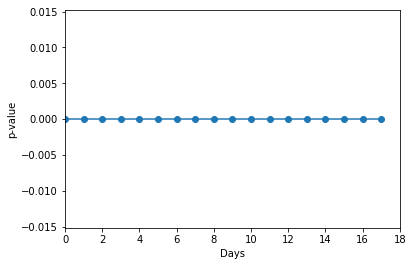

In [55]:
x = list(range(len(historical_p)))
y = historical_p

plt.scatter(x, y)
plt.plot(historical_p)
plt.ylabel('p-value')
plt.xlabel('Days')
plt.xlim(0,18)
plt.show()

# note we did not include the first four days of the test
# due to the way the data is gathered

### Test Results

The test results were statistically significant, so we can positively say that the Control (original version of the search results output) has performed better than the Variation (5-Tier Ranking Model).

In [62]:
print("Control Click Thru Rate: {0:.2f}%".format(Y1 * 100))
print("Variation Click Thru Rate: {0:.2f}%".format(Y2 * 100))

Control Click Thru Rate: 93.37%
Variation Click Thru Rate: 91.33%


<b>Winner</b>: Control 

<b><u>References</b></u>
<br>
[1] Sauro, Jeff, and James R. Lewis. <i>Quantifying the User Experience: Practical Statistics for User Research</i>. Morgan Kaufmann, 2016.
<br>
<br>
[2] Campbell, I. (2007), <i>Chi‐squared and Fisher–Irwin tests of two‐by‐two tables with small sample recommendations</i>. Statist. Med., 26: 3661-3675. doi:10.1002/sim.2832
<br>
<br>
[3] Wallis, Sean. <i>z-Squared: The Origin and Application of χ2</i>. 2010, www.ucl.ac.uk/english-usage/staff/sean/resources/z-squared.pdf.

<b>Quote from <i>Quantifying the User Experience: Practical Statistics for User Research</i> p. 73:</b>
<p>"Comparing the two outcomes of binary variables for two independent groups happens to be one of the most frequently computed procedures in applied statistics.  Surprisingly, there is little agreement on the best statistical test for this situation. For large sample sizes, the chi-square test is typically recommended. However, there is disagreement on what constitutes a 'small' or 'large' sample size and what version of these tests to use. A recent survey of medical and general statistics textbooks by Campbell (2007) found that only 2 of 14 books agreed on what procedure to recommend for comparing two independent binary outcomes.</p>
<p>The latest research suggests that a slight adjustment to the standard chi-square test, and equivalently to the two-proportion test, generates the best results for almost all sample sizes. The adjustment is simply subtracting 1 from the total sample size and using it in the standard chi-square or two-proportion test formulas. Because there is so much debate on this topic we spend the next few pages describing the alternatives which you are likely to encounter (or were taught) and then present the recommended N-1 chi-square test and N-1 two-proportion test."</p>